<a href="https://colab.research.google.com/github/esraregar/GA-on-VRPTW-with-roaming-locations/blob/main/GA_on_VRPRDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Program ini mencari rute pengiriman menggunakan algoritma genetika. Setiap pelanggan memiliki 1 lokasi rumah dan 1 lokasi cadangan. Setiap lokasi tersebut memiliki time window sesuai dengan keberadaan pelanggan pada lokasi tersebut. Tujuan masalah adalah mencari rute pengiriman yang mengunjungi seluruh pelanggan tepat sekali bisa pada lokasi rumah atau lokasi cadangan dengan biaya seoptimal mungkin

In [ ]:
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
!pip install haversine

In [ ]:
from haversine import haversine

In [ ]:
xls = pd.ExcelFile('Data.xlsx')
datacontoh = pd.read_excel(xls)


In [ ]:
lokasi = list(datacontoh['Lokasi'])
latitude = datacontoh['Latitude']
longitude = datacontoh['Longitude']
earliest_time = datacontoh['START']
latest_time = datacontoh['END']
d = datacontoh['Permintaan']
sumloc = max(lokasi)+1
velocity = 30
vehicle_capacity = 50

In [ ]:
a=[]
b=[]
for i in earliest_time:
  time = list(map(int,str(i).split(':')))
  start = (time[0]-7) + (time[1]/60) +(time[2]/3600)
  a.append(round(start,4))
for i in latest_time:
  time = list(map(int,str(i).split(':')))
  end = (time[0]-7) + (time[1]/60) +(time[2]/3600)
  b.append(round(end,4))

In [ ]:
t = [([0]*sumloc) for i in range (sumloc)]
for i in range (sumloc):
    for j in range (sumloc):
        t[i][j] = round((haversine((latitude[i],longitude[i]),(latitude[j],longitude[j])))/velocity,4)

In [ ]:
def mutation(individual):
    size = len(individual)
    child = [0]*size
    point1, point2 = random.sample(range(len(individual)), 2)
    child[point2] = individual[point1]
    for j in range(size):
        if j != point2:
            i = 0
            while i < size:
                if individual[i] not in child:
                    child[j] = individual[i]
                    i = size
                else:
                    i=i+1
    return child

In [ ]:
def crossover(ind1,ind2):
    point=[]
    size = min(len(ind1),len(ind2))
    child1 = [0]*size
    child2 = [0]*size
    n = random.randint(1,size-1)
    while len(point) < n:
        temp = random.randint(0,size-1)
        if temp not in point:
            point.append(temp)
    for k in point:
        child1[k] = ind1[k]
    for j in range(size):
        if j not in point:
            i = 0
            while i < size:
                if ind2[i] <= size:
                    if ind2[i] not in child1 and (ind2[i]+size) not in child1:
                      child1[j] = ind2[i]
                      i = size
                    else:
                        i=i+1
                else:
                    if ind2[i] not in child1 and (ind2[i]-size) not in child1:
                      child1[j] = ind2[i]
                      i = size
                    else:
                        i=i+1
    for k in point:
        child2[k] = ind2[k]
    for j in range(size):
        if j not in point:
            i = 0
            while i < size:
                if ind1[i] <= size:
                    if ind1[i] not in child2 and (ind1[i]+size) not in child2:
                      child2[j] = ind1[i]
                      i = size
                    else:
                        i=i+1
                else:
                    if ind1[i] not in child2 and (ind1[i]-size) not in child2:
                      child2[j] = ind1[i]
                      i = size
                    else:
                        i=i+1
    return child1,child2

In [ ]:
def fitness(individual):
    solution = []
    solution_desc = []
    i = 1
    route = [0]
    route_desc= "Rute " + str(i) + " = 0"
    vehicle_load = 0
    elapsed_time = 0
    last_customer_id = 0
    timecost = 0
    for customer_id in individual:
        return_time = t[customer_id][0]
        # Update vehicle load
        updated_vehicle_load = vehicle_load + d[customer_id]
        # Update elapsed time
        updated_elapsed_time = elapsed_time + t[last_customer_id][customer_id] + return_time
        # Validate vehicle load and elapsed time
        if (updated_vehicle_load <= vehicle_capacity) and ((updated_elapsed_time - return_time) <= b[customer_id]) and (updated_elapsed_time <= 10):
            # Add to current route
            route.append(customer_id)
            route_desc = route_desc + "-" + str(customer_id)
            vehicle_load = updated_vehicle_load
            if (updated_elapsed_time - return_time) < a[customer_id]:
                elapsed_time = a[customer_id]
            else:
                elapsed_time = updated_elapsed_time - return_time
        else:
            # Save current route
            route.append(0)
            route_desc = route_desc + "-0"
            solution.append(route)
            solution_desc.append(route_desc)
            timecost = timecost + elapsed_time + t[last_customer_id][0]
            # Initialize a new route and add to it
            route = [0]
            route.append(customer_id)
            i = i+1
            route_desc= "Rute " + str(i) + " = 0-" + str(customer_id)
            vehicle_load = d[customer_id]
            if t[0][customer_id] < a[customer_id]:
                elapsed_time = a[customer_id]
            else:
                elapsed_time = t[0][customer_id]
            
        # Update last customer ID
        last_customer_id = customer_id

    route.append(0)
    route_desc = route_desc + "-0"
    solution.append(route)
    solution_desc.append(route_desc)
    timecost = timecost + elapsed_time + return_time
    cost = int(timecost*20000+(80000*len(solution)))
    description = " ; ".join(str(elem) for elem in solution_desc)
    return (individual,solution,description,round(timecost,4),cost)

In [ ]:
fitness([15,35,60,33,36,24,29,39,8,40,43,58,49,23,47,55,48,52,51,42,50,31,32,26,46,34,37,41,44,57])

([15,
  35,
  60,
  33,
  36,
  24,
  29,
  39,
  8,
  40,
  43,
  58,
  49,
  23,
  47,
  55,
  48,
  52,
  51,
  42,
  50,
  31,
  32,
  26,
  46,
  34,
  37,
  41,
  44,
  57],
 [[0, 15, 35, 60, 33, 36, 0],
  [0, 24, 29, 39, 8, 40, 43, 58, 49, 0],
  [0, 23, 47, 55, 48, 52, 51, 42, 50, 31, 0],
  [0, 32, 26, 46, 34, 37, 41, 44, 57, 0]],
 'Rute 1 = 0-15-35-60-33-36-0 ; Rute 2 = 0-24-29-39-8-40-43-58-49-0 ; Rute 3 = 0-23-47-55-48-52-51-42-50-31-0 ; Rute 4 = 0-32-26-46-34-37-41-44-57-0',
 10.2354,
 524708)

In [ ]:
def elitism(sol,popsize):
    pop = sorted(sol, key = lambda sol: sol[4], reverse=False)
    pop = pop[:popsize]
    return pop

In [ ]:
def con(long,lat):
    y = 1200 * (180 + lat) / 360
    x = 800 * (90 + long) / 180
    return (x,y)

In [ ]:
def graf(loc,route):
    if loc == route:
        G = nx.DiGraph()

        for i in range(len(loc)):
            G.add_node(i, pos=con(longitude[i],latitude[i]))

        for i in range(len(loc)):
            for j in range(len(loc)):
                G.add_edges_from([(i,j)])

        plt.figure(3,figsize=(24,16)) 
        nx.draw_networkx_nodes(G, nx.get_node_attributes(G, 'pos'), node_color = 'white', node_size = 500, edgecolors='black')
        nx.draw_networkx_labels(G, nx.get_node_attributes(G, 'pos'), font_size=13)
        nx.draw_networkx_edges(G, nx.get_node_attributes(G, 'pos'), edgelist=G.edges(), edge_color='lightgrey',arrows=False,width=0.1)

        plt.show()

    else:
        G = nx.DiGraph()

        for i in range(len(loc)):
            G.add_node(i, pos=con(longitude[i],latitude[i]))

        for i in range(len(loc)):
            for j in range(len(loc)):
                G.add_edges_from([(i,j)])

        route_edges =[]
        for i in range(len(route)):
            for j in range(len(route[i])-1):
                route_edges.append((route[i][j],route[i][j+1])) 

        plt.figure(3,figsize=(24,16)) 
        nx.draw_networkx_nodes(G, nx.get_node_attributes(G, 'pos'), node_color = 'white', node_size = 500, edgecolors='black')
        nx.draw_networkx_labels(G, nx.get_node_attributes(G, 'pos'), font_size=13)
        nx.draw_networkx_edges(G, nx.get_node_attributes(G, 'pos'), edgelist=route_edges, edge_color='black', arrows=True,arrowsize=30, width=2.0)
        nx.draw_networkx_edges(G, nx.get_node_attributes(G, 'pos'), edgelist=G.edges(), edge_color='lightgrey',arrows=False, width=0.1)

        plt.show()

In [ ]:
def GA(generation,pop,popsize,cr,mr):
    sol = []
    for ind in pop:
        sol.append(fitness(ind))
    
    pop = elitism(sol,popsize)
    data = pd.DataFrame(pop)
    data.columns = ["Kromosom","Decoded","Solusi","Total Waktu Operasional","Total Biaya"]
    del data['Kromosom']
    del data['Decoded']
    data.index += 1
    pd.set_option('max_columns', None)
    pd.set_option('display.max_colwidth', None)
    print("Graf Lokasi")
    graf(lokasi,lokasi)
    print("Populasi Awal")
    print(data)
    for i in range(1,generation+1):
        print("\nGenerasi -",i)

        solutions_to_cross_over = elitism(pop,popsize)
        parent = list(zip(solutions_to_cross_over,solutions_to_cross_over[1:]))[::2]
        child = []
        for i,j in parent:
            if random.random() <= cr:
                offspring = crossover(i[0],j[0])
                for k in range(2):
                    child.append(fitness(offspring[k])) 
                    pop.append(fitness(offspring[k]))
            else:
                child.append(fitness(i[0]))
                child.append(fitness(j[0]))
                pop.append(fitness(i[0]))
                pop.append(fitness(j[0]))

        solutions_to_mutate = child
        for i in solutions_to_mutate:
            if random.random() <= mr:
                pop.append(fitness(mutation(i[0])))
            else:
                pop.append(fitness(i[0]))

        pop = elitism(pop,popsize)
        data = pd.DataFrame(pop)
        data.columns = ["Kromosom","Decoded","Solusi","Total Waktu Operasional","Total Biaya"]
        del data['Kromosom']
        del data['Decoded']
        data.index += 1
        pd.set_option('max_columns', None)
        pd.set_option('display.max_colwidth', None)
        print(data)

    print("\nIlustrasi Solusi")
    graf(lokasi,pop[0][1])

In [ ]:
pop=[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
,[31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
,[28, 44, 53, 59, 22, 18, 43, 46, 57, 56, 21, 37, 32, 45, 12, 35, 11, 55, 9, 24, 3, 20, 47, 6, 49, 8, 4, 60, 1, 40]
,[48, 54, 9, 8, 58, 1, 23, 60, 55, 11, 12, 5, 19, 50, 36, 2, 15, 33, 14, 27, 26, 34, 59, 22, 7, 16, 21, 47, 13, 40]
,[28, 22, 49, 16, 59, 36, 24, 56, 40, 33, 30, 45, 47, 37, 9, 20, 41, 2, 57, 12, 18, 8, 44, 5, 51, 25, 53, 43, 4, 31]
,[13, 58, 52, 59, 10, 57, 48, 34, 56, 32, 8, 6, 3, 50, 39, 30, 5, 44, 45, 41, 55, 42, 54, 49, 7, 46, 51, 1, 17, 53]
,[30, 36, 52, 17, 3, 5, 50, 39, 12, 38, 18, 4, 53, 49, 25, 2, 43, 1, 37, 51, 26, 28, 29, 24, 41, 14, 45, 46, 27, 40]
,[49, 24, 52, 20, 27, 43, 42, 31, 25, 32, 10, 9, 29, 46, 60, 3, 7, 53, 5, 28, 14, 26, 47, 41, 38, 36, 34, 51, 15, 18]
,[26, 34, 20, 45, 36, 11, 39, 1, 51, 29, 14, 19, 53, 54, 60, 10, 47, 5, 7, 52, 43, 16, 38, 3, 48, 32, 12, 28, 55, 27]
,[43, 41, 56, 35, 50, 44, 27, 18, 3, 58, 12, 37, 4, 22, 29, 9, 45, 55, 8, 1, 23, 49, 60, 54, 16, 36, 51, 10, 47, 32]
,[32, 14, 1, 37, 57, 28, 4, 43, 21, 9, 10, 52, 12, 17, 3, 11, 59, 49, 48, 6, 45, 23, 38, 5, 46, 55, 30, 20, 26, 24]
,[38, 9, 26, 37, 34, 29, 23, 12, 45, 51, 17, 32, 58, 20, 52, 41, 54, 55, 46, 33, 57, 19, 60, 35, 40, 1, 14, 18, 13, 6]
,[55, 18, 56, 6, 30, 44, 10, 11, 58, 35, 34, 59, 32, 3, 57, 31, 17, 52, 42, 8, 53, 13, 45, 39, 20, 37, 46, 51, 49, 54]
,[28, 15, 19, 18, 39, 2, 46, 53, 24, 20, 33, 26, 29, 1, 12, 27, 51, 22, 7, 11, 5, 10, 60, 43, 6, 55, 34, 17, 8, 44]
,[5, 4, 6, 23, 25, 58, 59, 14, 7, 54, 45, 41, 42, 2, 52, 17, 46, 30, 27, 33, 10, 50, 9, 13, 51, 19, 8, 26, 31, 48]
,[35, 51, 59, 38, 58, 12, 1, 11, 23, 54, 16, 47, 55, 36, 43, 7, 39, 48, 19, 60, 44, 15, 4, 2, 27, 26, 3, 22, 10, 20]
,[46, 53, 30, 28, 14, 42, 20, 47, 39, 18, 25, 51, 3, 26, 13, 45, 41, 27, 31, 22, 49, 2, 36, 7, 24, 38, 5, 4, 40, 59]
,[48, 33, 51, 37, 59, 36, 39, 50, 24, 47, 55, 60, 41, 15, 52, 58, 8, 26, 16, 49, 31, 53, 57, 12, 10, 44, 5, 43, 4, 32]
,[16, 11, 4, 59, 60, 52, 1, 24, 37, 58, 43, 5, 19, 36, 45, 47, 48, 56, 33, 38, 42, 55, 23, 14, 50, 21, 39, 57, 2, 10]
,[2, 27, 7, 45, 59, 17, 42, 34, 3, 36, 52, 20, 28, 56, 13, 60, 40, 9, 19, 8, 41, 21, 44, 16, 5, 25, 1, 54, 23, 18]
,[31, 22, 38, 45, 43, 42, 46, 30, 17, 18, 20, 23, 11, 32, 59, 5, 28, 55, 9, 49, 37, 44, 40, 57, 3, 51, 54, 26, 4, 6]
,[28, 18, 22, 3, 24, 10, 2, 9, 6, 57, 5, 7, 11, 38, 60, 51, 47, 4, 43, 46, 49, 42, 56, 25, 45, 20, 29, 14, 53, 1]
,[54, 14, 57, 19, 39, 45, 59, 7, 55, 26, 43, 22, 28, 4, 48, 33, 40, 5, 46, 23, 6, 1, 41, 30, 42, 8, 47, 50, 2, 51]
,[26, 12, 24, 35, 39, 32, 44, 53, 51, 37, 43, 47, 29, 33, 36, 11, 27, 40, 58, 50, 48, 25, 30, 4, 46, 15, 8, 19, 1, 22]
,[10, 7, 11, 12, 1, 4, 55, 8, 45, 16, 20, 30, 39, 51, 52, 56, 57, 54, 53, 19, 36, 44, 43, 32, 29, 48, 47, 3, 28, 35]
,[38, 35, 13, 40, 23, 22, 30, 14, 34, 11, 54, 57, 18, 31, 9, 37, 6, 26, 17, 19, 29, 33, 15, 55, 20, 21, 16, 42, 28, 32]
,[8, 50, 41, 17, 9, 32, 22, 1, 12, 33, 6, 56, 34, 25, 49, 5, 29, 60, 18, 23, 57, 54, 10, 14, 21, 58, 16, 37, 13, 45]
,[13, 15, 12, 25, 14, 3, 37, 40, 24, 31, 35, 48, 50, 23, 39, 47, 28, 21, 6, 41, 59, 49, 32, 34, 8, 52, 57, 60, 46, 56]
,[4, 56, 7, 19, 54, 58, 1, 50, 39, 40, 27, 25, 3, 6, 2, 44, 29, 5, 42, 46, 13, 52, 23, 17, 18, 15, 30, 21, 38, 41]
,[41, 28, 22, 19, 31, 32, 46, 37, 44, 47, 4, 13, 29, 25, 12, 24, 39, 51, 36, 30, 57, 3, 53, 38, 48, 15, 56, 20, 40, 35]]

In [ ]:
pophome = [[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
,[5, 17, 16, 28, 2, 6, 1, 15, 9, 20, 21, 30, 12, 3, 27, 4, 26, 13, 24, 10, 19, 11, 14, 7, 23, 8, 25, 29, 22, 18]
,[2, 23, 9, 5, 10, 11, 16, 22, 30, 1, 27, 12, 14, 19, 26, 4, 25, 29, 13, 18, 24, 7, 20, 8, 21, 28, 15, 17, 6, 3]
,[9, 5, 8, 23, 20, 13, 10, 11, 17, 4, 16, 30, 22, 3, 21, 7, 2, 26, 25, 15, 6, 14, 27, 28, 12, 29, 24, 18, 19, 1]
,[27, 1, 15, 4, 30, 12, 17, 13, 6, 29, 23, 22, 3, 8, 20, 11, 9, 28, 16, 26, 14, 18, 25, 21, 10, 7, 5, 19, 2, 24]
,[20, 3, 24, 21, 11, 1, 19, 16, 12, 13, 30, 10, 9, 15, 17, 26, 6, 14, 7, 5, 22, 2, 8, 25, 29, 4, 27, 28, 18, 23]
,[7, 1, 5, 25, 9, 16, 30, 18, 8, 24, 17, 22, 26, 27, 3, 13, 10, 4, 14, 11, 23, 2, 19, 20, 15, 12, 21, 29, 6, 28]
,[16, 27, 14, 24, 29, 11, 6, 5, 26, 21, 22, 28, 2, 18, 19, 25, 15, 3, 9, 17, 23, 30, 10, 8, 7, 4, 13, 20, 1, 12]
,[23, 4, 10, 13, 14, 6, 16, 3, 12, 22, 11, 29, 1, 28, 25, 2, 20, 24, 7, 5, 19, 26, 27, 9, 17, 21, 15, 8, 18, 30]
,[28, 14, 18, 25, 19, 11, 24, 3, 2, 10, 15, 17, 4, 23, 1, 5, 12, 30, 20, 26, 22, 13, 16, 29, 9, 6, 7, 8, 21, 27]
,[13, 28, 7, 17, 22, 3, 26, 30, 16, 15, 5, 25, 20, 23, 8, 11, 14, 12, 19, 27, 1, 29, 2, 24, 9, 21, 4, 6, 10, 18]
,[24, 1, 22, 3, 25, 29, 9, 18, 10, 30, 7, 11, 26, 23, 5, 17, 4, 16, 21, 13, 12, 15, 28, 8, 19, 2, 6, 14, 20, 27]
,[16, 24, 21, 18, 6, 9, 17, 25, 26, 2, 1, 13, 28, 7, 14, 22, 4, 12, 15, 30, 19, 27, 10, 11, 29, 23, 8, 5, 3, 20]
,[27, 16, 19, 10, 5, 12, 14, 11, 21, 18, 7, 25, 26, 22, 8, 9, 30, 28, 24, 6, 1, 2, 20, 13, 23, 3, 4, 17, 29, 15]
,[19, 9, 22, 29, 30, 23, 16, 28, 4, 7, 25, 8, 10, 12, 26, 3, 6, 2, 1, 21, 15, 14, 18, 27, 17, 20, 11, 13, 5, 24]
,[27, 21, 20, 24, 16, 25, 19, 1, 29, 12, 10, 6, 8, 9, 15, 17, 11, 7, 4, 22, 23, 2, 26, 30, 13, 18, 3, 5, 14, 28]
,[17, 5, 29, 2, 7, 15, 24, 21, 16, 18, 13, 4, 8, 20, 19, 3, 12, 14, 9, 6, 22, 11, 26, 23, 30, 10, 28, 27, 1, 25]
,[16, 5, 7, 9, 25, 11, 20, 3, 13, 28, 26, 10, 23, 29, 30, 14, 19, 22, 12, 6, 27, 17, 15, 18, 8, 24, 4, 2, 21, 1]
,[26, 25, 30, 24, 22, 14, 12, 8, 28, 15, 10, 20, 4, 19, 9, 6, 17, 7, 13, 11, 18, 23, 2, 21, 3, 1, 29, 16, 27, 5]
,[5, 7, 8, 16, 23, 17, 28, 1, 9, 4, 27, 11, 2, 3, 21, 29, 14, 20, 10, 19, 6, 26, 25, 18, 15, 22, 30, 13, 24, 12]
,[10, 21, 12, 27, 3, 13, 5, 14, 9, 4, 26, 1, 8, 15, 30, 11, 2, 16, 24, 25, 20, 29, 28, 23, 7, 18, 6, 19, 17, 22]
,[10, 21, 23, 13, 19, 25, 12, 17, 9, 11, 2, 22, 8, 26, 3, 6, 1, 18, 7, 5, 16, 15, 14, 30, 27, 4, 20, 29, 24, 28]
,[7, 24, 11, 22, 4, 12, 9, 16, 1, 18, 15, 2, 5, 3, 21, 25, 23, 17, 26, 8, 14, 13, 27, 10, 20, 19, 29, 6, 30, 28]
,[7, 22, 5, 15, 29, 27, 16, 4, 9, 13, 19, 18, 23, 3, 24, 28, 14, 25, 2, 11, 21, 8, 30, 1, 6, 20, 10, 12, 26, 17]
,[15, 1, 13, 5, 26, 20, 22, 16, 10, 23, 12, 14, 28, 11, 3, 25, 4, 24, 18, 6, 21, 19, 29, 17, 9, 2, 30, 7, 8, 27]
,[2, 29, 13, 20, 10, 14, 11, 3, 25, 5, 6, 18, 19, 26, 7, 12, 24, 30, 17, 9, 1, 4, 27, 23, 15, 21, 8, 16, 22, 28]
,[23, 7, 22, 30, 1, 28, 2, 20, 29, 10, 4, 12, 17, 5, 6, 8, 15, 13, 16, 14, 11, 27, 19, 18, 26, 9, 24, 25, 3, 21]
,[18, 5, 28, 1, 9, 24, 26, 8, 16, 29, 14, 19, 30, 15, 17, 20, 6, 25, 10, 22, 12, 21, 3, 11, 27, 13, 23, 2, 7, 4]
,[29, 27, 8, 2, 5, 23, 21, 7, 16, 13, 11, 25, 14, 15, 9, 19, 26, 20, 4, 24, 30, 17, 3, 6, 10, 18, 12, 22, 28, 1]]

Graf Lokasi


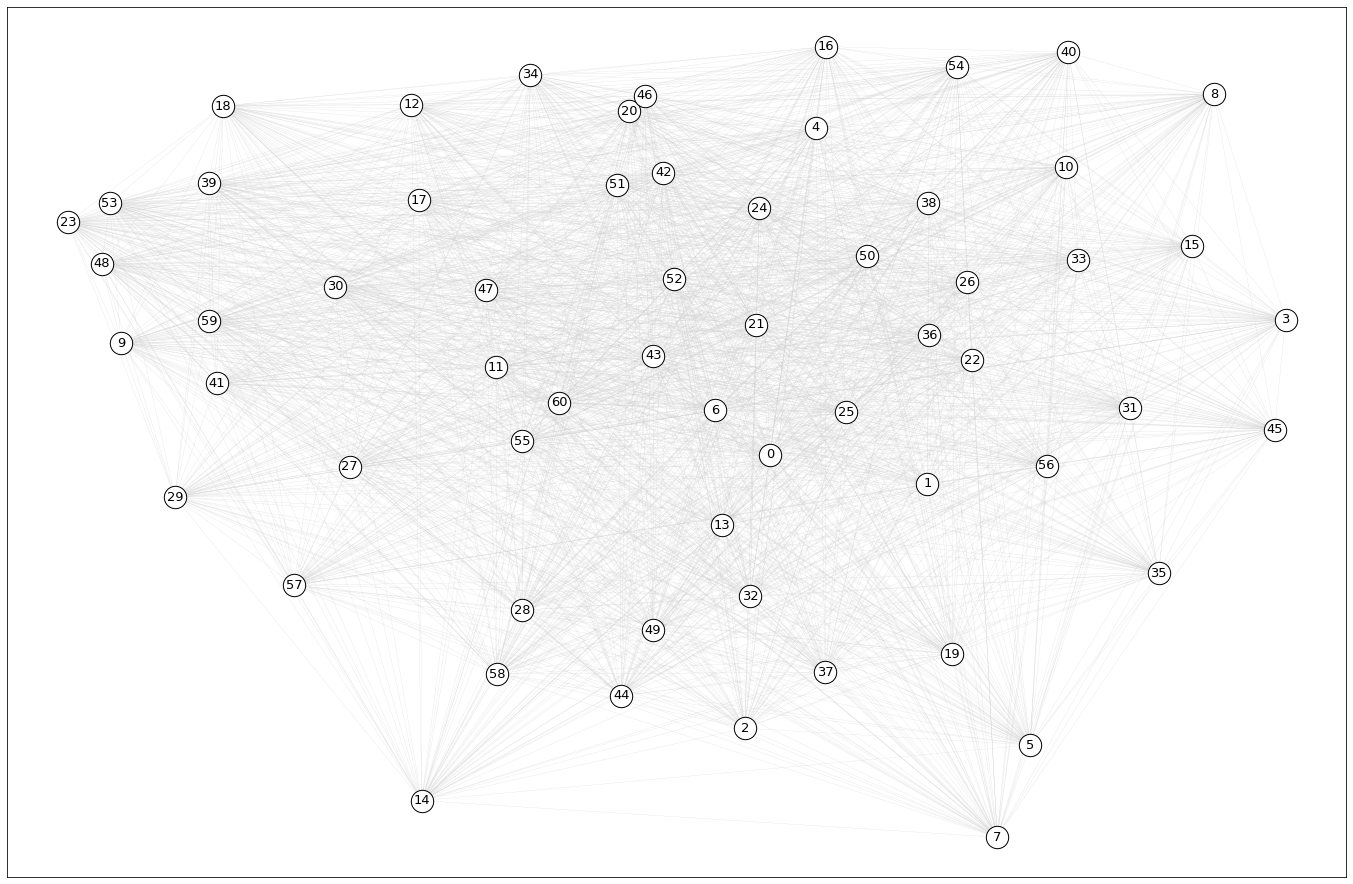

Streaming output truncated to the last 5000 lines.
5   Rute 1 = 0-11-21-36-52-50-1-0 ; Rute 2 = 0-24-3-4-60-32-37-0 ; Rute 3 = 0-19-40-46-45-47-48-56-43-38-0 ; Rute 4 = 0-35-42-55-23-58-44-59-39-57-0   
6   Rute 1 = 0-32-11-21-36-52-50-1-37-0 ; Rute 2 = 0-24-3-4-60-0 ; Rute 3 = 0-19-40-46-45-47-48-56-43-38-0 ; Rute 4 = 0-35-42-55-23-58-44-59-39-57-0   
7   Rute 1 = 0-32-11-21-36-52-50-1-37-0 ; Rute 2 = 0-24-3-4-60-0 ; Rute 3 = 0-19-40-46-45-47-48-56-43-38-0 ; Rute 4 = 0-35-42-55-23-58-44-59-39-57-0   
8   Rute 1 = 0-32-11-21-36-52-50-1-37-0 ; Rute 2 = 0-24-3-4-60-0 ; Rute 3 = 0-19-40-46-45-47-48-56-43-38-0 ; Rute 4 = 0-35-42-55-23-58-44-59-39-57-0   
9   Rute 1 = 0-32-11-21-36-52-50-1-37-0 ; Rute 2 = 0-24-3-4-60-0 ; Rute 3 = 0-19-40-46-45-47-48-56-43-38-0 ; Rute 4 = 0-35-42-55-23-58-44-59-39-57-0   
10  Rute 1 = 0-32-11-21-36-52-50-1-37-0 ; Rute 2 = 0-24-3-4-60-0 ; Rute 3 = 0-19-40-46-45-47-48-56-43-38-0 ; Rute 4 = 0-35-42-55-23-58-44-59-39-57-0   
11  Rute 1 = 0-32-11-36-52-50-0 ; Rut

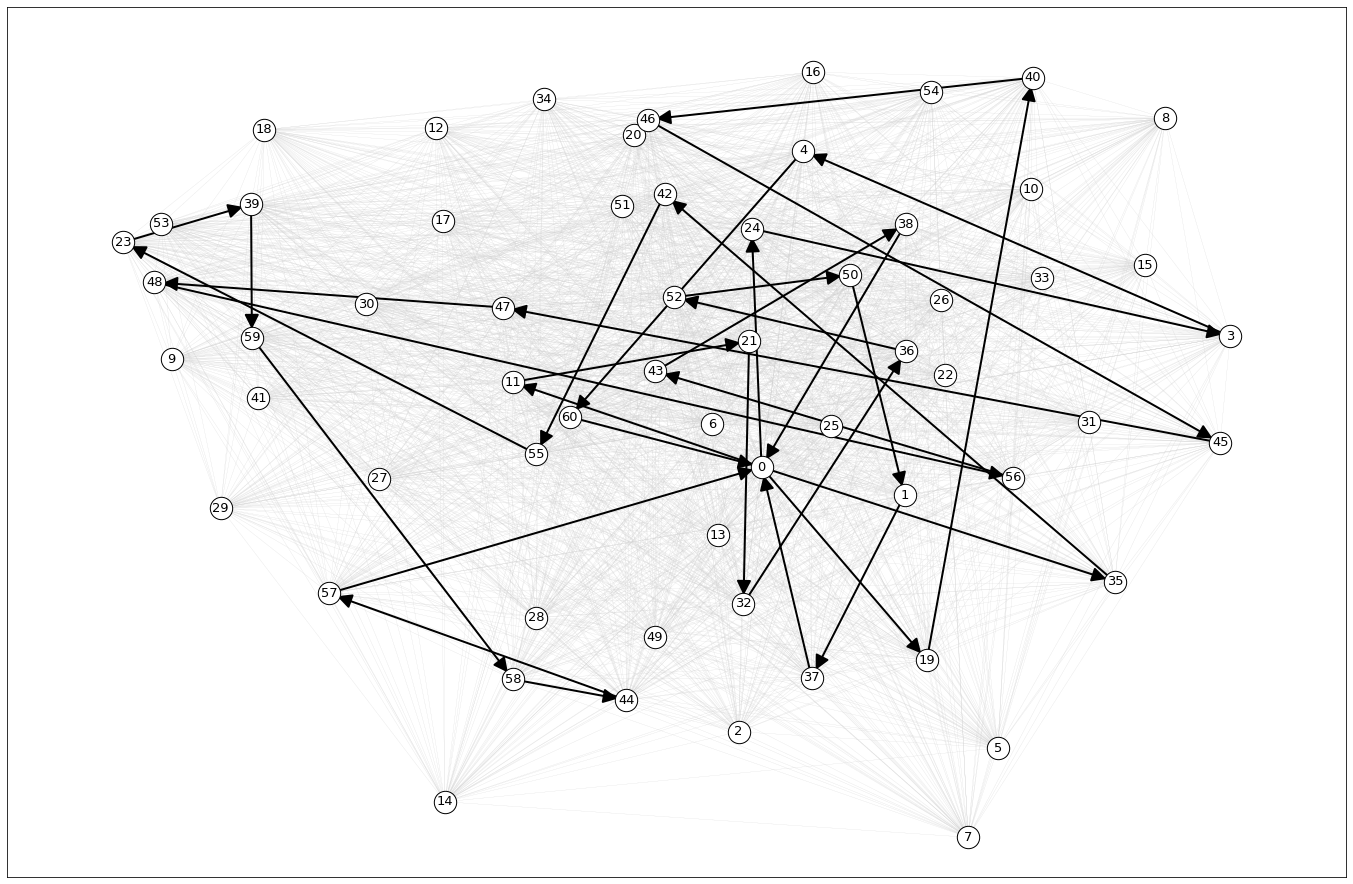

In [ ]:
GA(100,pop,30,0.7,0.5)

Graf Lokasi


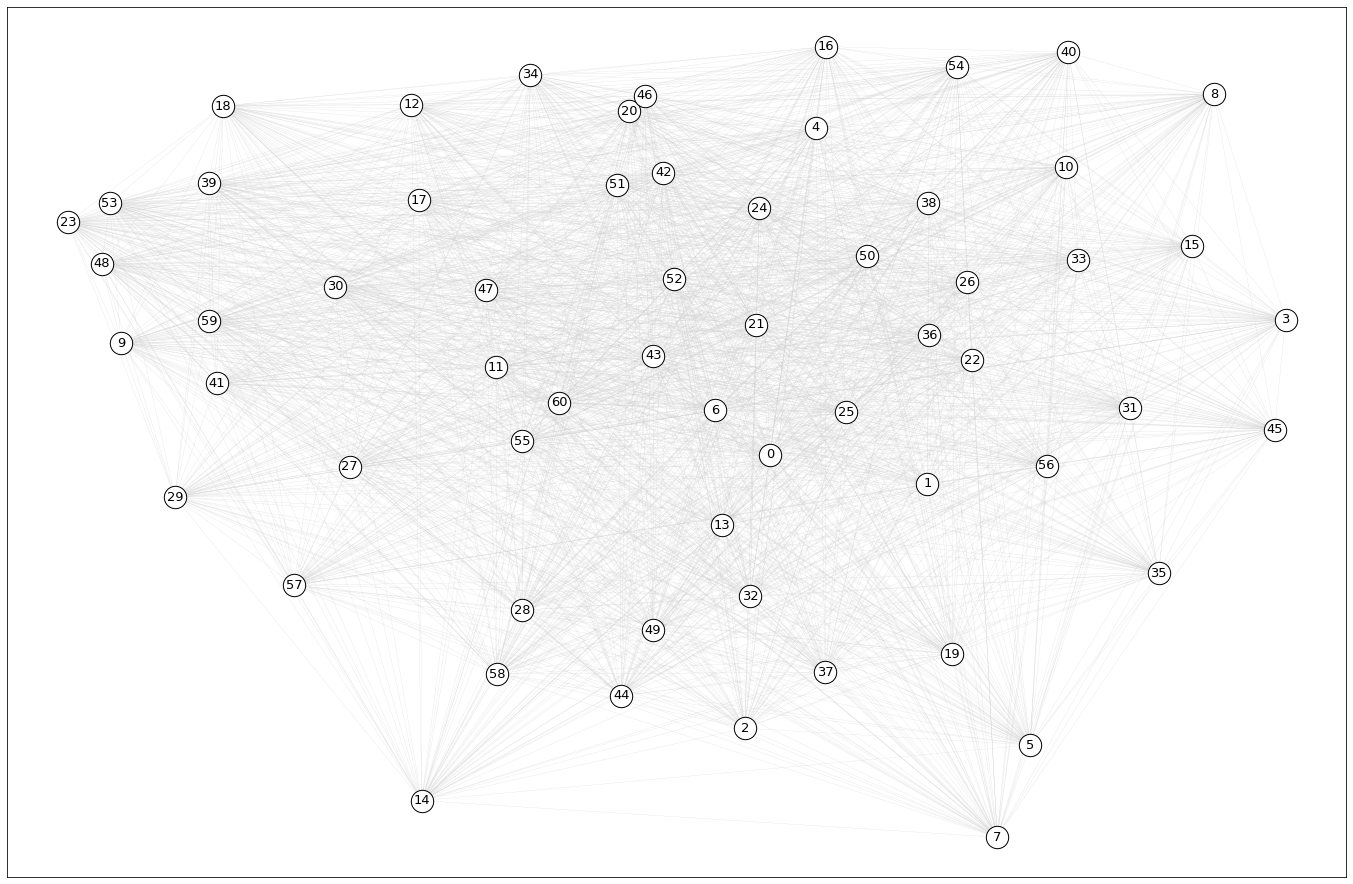

Streaming output truncated to the last 5000 lines.
5                  Rute 1 = 0-16-24-21-0 ; Rute 2 = 0-6-9-30-17-0 ; Rute 3 = 0-25-2-1-13-28-7-14-0 ; Rute 4 = 0-22-26-4-12-27-19-0 ; Rute 5 = 0-15-10-0 ; Rute 6 = 0-20-11-18-23-29-0 ; Rute 7 = 0-5-3-8-0   
6                  Rute 1 = 0-16-24-21-0 ; Rute 2 = 0-6-9-30-17-0 ; Rute 3 = 0-25-2-1-13-28-7-14-0 ; Rute 4 = 0-22-26-4-12-27-19-0 ; Rute 5 = 0-15-10-0 ; Rute 6 = 0-20-11-18-23-29-0 ; Rute 7 = 0-5-3-8-0   
7                  Rute 1 = 0-16-24-21-0 ; Rute 2 = 0-6-9-30-17-0 ; Rute 3 = 0-25-2-1-13-28-7-14-0 ; Rute 4 = 0-22-26-4-12-27-19-0 ; Rute 5 = 0-15-10-0 ; Rute 6 = 0-20-11-18-23-29-0 ; Rute 7 = 0-5-3-8-0   
8                  Rute 1 = 0-16-24-21-0 ; Rute 2 = 0-6-9-30-17-0 ; Rute 3 = 0-25-2-1-13-28-7-14-0 ; Rute 4 = 0-22-26-4-12-27-19-0 ; Rute 5 = 0-15-10-0 ; Rute 6 = 0-20-11-18-23-29-0 ; Rute 7 = 0-5-3-8-0   
9                  Rute 1 = 0-16-24-21-0 ; Rute 2 = 0-6-9-30-17-0 ; Rute 3 = 0-25-2-1-13-28-7-14-0 ; Rute 4 = 0-22-26-4-12-27

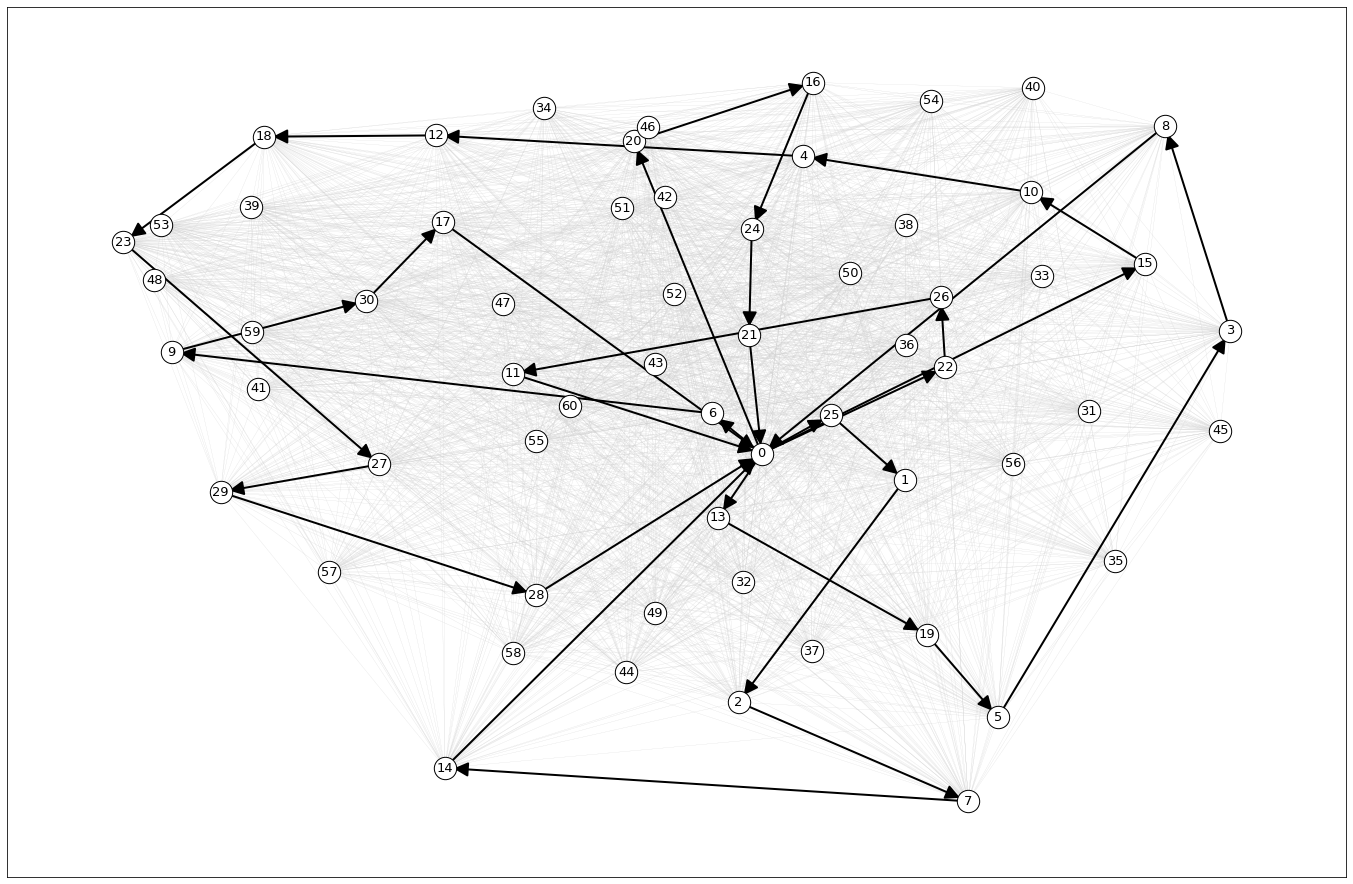

In [ ]:
GA(100,pophome,30,0.7,0.5)